# Multiple Linear Regression
---

## Housing Case Study

#### Problem Statement:

Consider a real estate company that has a dataset containing the prices of properties in the Delhi region. It wishes to use the data to optimise the sale prices of the properties based on important factors such as area, bedrooms, parking, etc.

Essentially, the company wants —


- To identify the variables affecting house prices, e.g. area, number of rooms, bathrooms, etc.

- To create a linear model that quantitatively relates house prices with variables such as number of rooms, area, number of bathrooms, etc.

- To know the accuracy of the model, i.e. how well these variables can predict house prices.

#### Task

- Predict the price of the house

In [1]:
#Suppress warnings
import warnings
warnings.filterwarnings("ignore")
import sys
import os

In [2]:
# getting the name of the directory
# where the this file is present.
current = os.path.dirname(os.path.realpath("ml_utils.py"))
  
# Getting the parent directory name
# where the current directory is present.
parent = os.path.dirname(current)
  
# adding the parent directory to 
# the sys.path.
sys.path.append(parent)

In [3]:
from ml_utils import *
sns.set_style("darkgrid")

In [4]:
import matplotlib.pyplot as pyplot

In [5]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, LassoCV, LassoLarsCV, MultiTaskLasso, LassoLars, ElasticNet, MultiTaskElasticNet, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import RFECV, RFE
from sklearn.model_selection import KFold, GridSearchCV
from scipy import stats

In [6]:
#Display settings
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [7]:
from sklearn import set_config
set_config(display="diagram")

In [8]:
#Load the dataset
df = pd.read_csv("Housing.csv")

## 1. Data Overview

In [9]:
#Visual overview of the dataset
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


## 3. Data Pre-Processing

### Get the list of categorical and numerical columns

In [10]:
#Check the list of categorical columns
catCols = df.select_dtypes("object").columns
catCols = list(set(catCols))
print(catCols)

['prefarea', 'airconditioning', 'mainroad', 'guestroom', 'hotwaterheating', 'basement', 'furnishingstatus']


In [11]:
#Check the list of numerical columns
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numCols = df.select_dtypes(include=numerics).columns
#Remove the price column
# numCols = np.delete(numCols, np.where(numCols == 'price'))
print(numCols)

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking'], dtype='object')


In [12]:
#Add Binary mapping to categorical columns
binaryColList = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']
binaryValList = ["no", "yes"]

---------

<AxesSubplot:xlabel='price', ylabel='Density'>

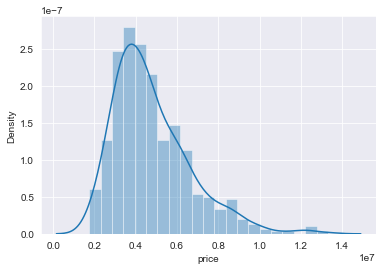

In [13]:
sns.distplot((df['price']))

In [14]:
df['price'] = stats.boxcox(df['price'] , 0)

<AxesSubplot:xlabel='price', ylabel='Density'>

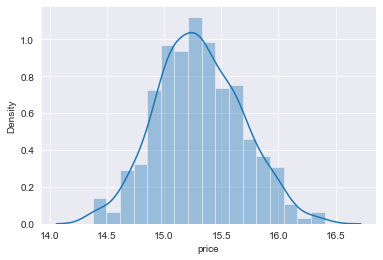

In [15]:
sns.distplot((df['price']))

### Train-Test Split

In [16]:
#Do the train-test split
train, test = model_selection.train_test_split( df , test_size = 0.2 , random_state = 42 )

## 4. Define Custom Transformers and Pipeline steps

### Define Custom Transformers

In [17]:
#Custom Transformer that transforms Categorical columns
class BinaryEncoding( BaseEstimator, TransformerMixin):
    
    #Class Constructor
    def __init__(self, binaryColList, binaryValList):
        self.binaryColList = binaryColList
        self.binaryValList = binaryValList
        pass
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        
        #Do Binary Mapping
        X[self.binaryColList] = X[self.binaryColList].apply(lambda x: x.map({"no": 0, "yes": 1}))
        return X

In [18]:
#Custom Transformer that transforms Categorical columns
class DummyEncoding( BaseEstimator, TransformerMixin):
    
    #Class Constructor
    def __init__(self):
        pass
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        
        #One-Hot Encoding of categorical columns
        #Get dummy variables
        X["furnishingstatus"] = pd.factorize(X["furnishingstatus"])[0]
        
        return X

In [19]:
#Custom Transformer that scales Numerical columns
class CustomScaler( BaseEstimator, TransformerMixin):
    
    #Class Constructor
    def __init__(self, numCols):
        self.numCols = numCols
        self.scaler = MinMaxScaler()
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        self.scaler.fit(X[numCols])
        return self
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        
        X[numCols] = self.scaler.transform(X[numCols])
        
        return X

### Setup Categorical and Numerical Pipeline

In [20]:
#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [('binaryEncodingTransformer', BinaryEncoding(binaryColList, binaryValList)), ('dummyEncodingTransformer', DummyEncoding())] )

In [21]:
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'min_max_scaler', CustomScaler(numCols)) ] )

### Setup pre-process pipeline

In [22]:
preprocess_pipeline = Pipeline(steps = [('numerical', numerical_pipeline),('categorical', categorical_pipeline)])

In [23]:
#Fit_transform the pipeline on training data
train_transform = preprocess_pipeline.fit_transform(train)

In [24]:
#Transform the pipeline on test data
test_transform = preprocess_pipeline.transform(test)

In [25]:
train_transform.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
46,0.749580,0.298969,0.4,0.333333,1.000000,1,0,0,0,1,0.333333,0,0
93,0.658270,0.381443,0.4,0.333333,0.000000,1,0,1,0,1,1.000000,0,1
335,0.414447,0.148866,0.2,0.000000,0.000000,1,0,1,0,1,0.666667,0,0
412,0.345825,0.065979,0.4,0.000000,0.333333,1,0,1,0,0,0.000000,1,2
471,0.278700,0.144330,0.4,0.000000,0.333333,1,0,0,0,0,0.000000,0,2


### Extract X and y

In [26]:
#Extract y - the dependent variable
y_train = train_transform.pop('price')
y_test = test_transform.pop('price')

In [27]:
#Store the independent variables in X
X_train = train_transform
X_test = test_transform

### Initialize the model

In [28]:
#Initialize the model
lr = LinearRegression()

### RFE

In [29]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(2, 13):
        rfe = RFE(estimator=lr, n_features_to_select=i)
        model = LinearRegression()
        models[str(i)] = Pipeline(steps=[('selection',rfe),('model',lr)])
    return models

In [30]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    folds = model_selection.KFold(n_splits = 10, shuffle = True, random_state = 100)
    scores = model_selection.cross_val_score(model, X_train, y_train,
                         scoring="r2",
                         cv=folds, n_jobs=-1)
    
    return scores

In [31]:
# get the models to evaluate
models = get_models()

In [32]:
models

{'2': Pipeline(steps=[('selection',
                  RFE(estimator=LinearRegression(), n_features_to_select=2)),
                 ('model', LinearRegression())]),
 '3': Pipeline(steps=[('selection',
                  RFE(estimator=LinearRegression(), n_features_to_select=3)),
                 ('model', LinearRegression())]),
 '4': Pipeline(steps=[('selection',
                  RFE(estimator=LinearRegression(), n_features_to_select=4)),
                 ('model', LinearRegression())]),
 '5': Pipeline(steps=[('selection',
                  RFE(estimator=LinearRegression(), n_features_to_select=5)),
                 ('model', LinearRegression())]),
 '6': Pipeline(steps=[('selection',
                  RFE(estimator=LinearRegression(), n_features_to_select=6)),
                 ('model', LinearRegression())]),
 '7': Pipeline(steps=[('selection',
                  RFE(estimator=LinearRegression(), n_features_to_select=7)),
                 ('model', LinearRegression())]),
 '8': Pipeline(s

In [33]:
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

>2 0.406 (0.151)
>3 0.466 (0.132)
>4 0.460 (0.163)
>5 0.507 (0.159)
>6 0.545 (0.143)
>7 0.584 (0.122)
>8 0.596 (0.123)
>9 0.614 (0.126)
>10 0.632 (0.114)
>11 0.636 (0.125)
>12 0.649 (0.127)


In [34]:
results

[array([0.24225262, 0.23616817, 0.54753473, 0.54288873, 0.09787661,
        0.44560273, 0.47425644, 0.47806612, 0.42584761, 0.56901352]),
 array([0.25227087, 0.34570161, 0.47940624, 0.63336567, 0.26747471,
        0.46858521, 0.51711113, 0.59215492, 0.47219939, 0.62941025]),
 array([0.12228618, 0.41029391, 0.46170995, 0.68719004, 0.23633008,
        0.52067128, 0.51580267, 0.63389435, 0.44545342, 0.56409684]),
 array([0.19186479, 0.47396585, 0.52896397, 0.67637354, 0.24465723,
        0.57867736, 0.56341574, 0.69257542, 0.5168458 , 0.60721686]),
 array([0.28069106, 0.52424781, 0.6110747 , 0.72973781, 0.3035933 ,
        0.61847041, 0.55758609, 0.7163801 , 0.51218108, 0.59462963]),
 array([0.32505741, 0.60991355, 0.61111249, 0.73018297, 0.44903631,
        0.64647002, 0.6178267 , 0.7417941 , 0.48695308, 0.62410832]),
 array([0.32197394, 0.60458121, 0.63267568, 0.7321502 , 0.47065911,
        0.65932656, 0.61866914, 0.75848377, 0.51480685, 0.64428539]),
 array([0.33686552, 0.63033815, 0.

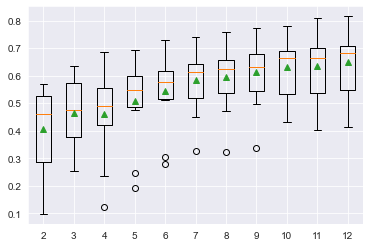

In [35]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

### RFECV

In [36]:
model = LinearRegression()
rfecv = RFECV(estimator = model, step=1, cv=5)

### Select the best performing model

In [37]:
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=8)
pipe = Pipeline(steps=[('selection',rfe), ('model', model)])

In [38]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('selection',
                 RFE(estimator=LinearRegression(), n_features_to_select=8)),
                ('model', LinearRegression())])

In [41]:
# summarize all features
for i in range(X_train.shape[1]):
	print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

Column: 0, Selected True, Rank: 1.000
Column: 1, Selected False, Rank: 3.000
Column: 2, Selected True, Rank: 1.000
Column: 3, Selected True, Rank: 1.000
Column: 4, Selected False, Rank: 2.000
Column: 5, Selected False, Rank: 5.000
Column: 6, Selected True, Rank: 1.000
Column: 7, Selected True, Rank: 1.000
Column: 8, Selected True, Rank: 1.000
Column: 9, Selected True, Rank: 1.000
Column: 10, Selected True, Rank: 1.000
Column: 11, Selected False, Rank: 4.000


In [42]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('area', True, 1),
 ('bedrooms', False, 3),
 ('bathrooms', True, 1),
 ('stories', True, 1),
 ('mainroad', False, 2),
 ('guestroom', False, 5),
 ('basement', True, 1),
 ('hotwaterheating', True, 1),
 ('airconditioning', True, 1),
 ('parking', True, 1),
 ('prefarea', True, 1),
 ('furnishingstatus', False, 4)]

In [43]:
#Visualize the selected columns
X_train.columns[rfe.support_]

Index(['area', 'bathrooms', 'stories', 'basement', 'hotwaterheating',
       'airconditioning', 'parking', 'prefarea'],
      dtype='object')

In [44]:
X_train_rfe = X_train[X_train.columns[rfe.support_]]

In [66]:
X_test_rfe = X_test[X_test.columns[rfe.support_]]

#### Model Predictions on the Train and Test set 

In [45]:
y_train_pred = pipe.predict(X_train)

In [46]:
y_test_pred = pipe.predict(X_test)

In [47]:
y_test_pred

array([0.58780147, 0.72217851, 0.28711028, 0.4511067 , 0.2848636 ,
       0.36237387, 0.54716561, 0.61360849, 0.28952327, 0.24947848,
       0.98305551, 0.28413343, 0.36260566, 0.38413839, 0.40857097,
       0.52844979, 0.28237432, 0.50406987, 0.48624756, 0.3421538 ,
       0.63301954, 0.59691969, 0.27612965, 0.50491921, 0.55085303,
       0.80294262, 0.33130331, 0.48147978, 0.87826529, 0.31045775,
       0.67028798, 0.3387075 , 0.63189411, 0.41197936, 0.36030584,
       0.5649028 , 0.47731485, 0.47086715, 0.35586564, 0.40462572,
       0.44751847, 0.36007816, 0.71993184, 0.36903761, 0.36321638,
       0.44828603, 0.68444836, 0.38139432, 0.39972484, 0.37853527,
       0.77563089, 0.28278325, 0.41674121, 0.50793727, 0.39930344,
       0.255376  , 0.77854992, 0.29360769, 0.40734559, 0.28037025,
       0.48374003, 0.38631532, 0.51363181, 0.46830141, 0.50273681,
       0.45037498, 0.7639313 , 0.38133004, 0.64185598, 0.61508531,
       0.55350995, 0.53361501, 0.43443377, 0.82515578, 0.35839

In [48]:
model.coef_

array([0.40861392, 0.30044921, 0.15766273, 0.07087229, 0.06881434,
       0.08448209, 0.07463921, 0.07624268])

## 5. Model Evaluation

In [49]:
class ModelEvaluation:
    
    def __init__(self, y_actual, y_pred):
        self.y_actual = y_actual
        self.y_pred = y_pred
    
    def calcMetrics(self):
        
        #Calculate Residuals
        self.resid = self.y_pred - self.y_actual

        #Calculate RMSE
        self.rmse = np.sqrt(metrics.mean_squared_error(self.y_actual, self.y_pred))
        
        #Calculate R-Squared
        self.r2_score = metrics.r2_score(self.y_actual,self.y_pred)
        
        #Calculate MAE
        self.mae = metrics.mean_absolute_error(self.y_actual, self.y_pred)
        
        #Calculate MSE
        self.mse = metrics.mean_squared_error(self.y_actual, self.y_pred)
    
    def plotResid(self, x_label, y_label):
        
        # Plotting y_test and y_pred to understand the spread
        fig = plt.figure()
        plt.scatter(self.y_pred, self.resid)
        fig.suptitle('{} vs {}'.format(y_label, x_label), fontsize = 20)              # Plot heading 
        plt.xlabel(x_label, fontsize = 18)                          # X-label
        plt.ylabel(y_label, fontsize = 16)  
    
    def plotResidDistribution(self):
        
        # Plot the histogram of the error terms
        fig = plt.figure()
        sns.distplot((self.resid), bins = 20)
        fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
        plt.xlabel('Errors', fontsize = 18)                         # X-label
        
    
    def printMetrics(self):
        
        print("Here are the evaluation results: ")
        print("----")
        print("MAE is {}".format(self.mae))
        print("MSE is {}".format(self.mse))
        print("RMSE is {}".format(self.rmse))
        print("R-Squared is {}".format(self.r2_score)) 

In [50]:
#Create modelResults object
mEvalTest = ModelEvaluation(y_test, y_test_pred)
mEvalTrain = ModelEvaluation(y_train, y_train_pred)

In [51]:
#Calculate the model metrics
mEvalTest.calcMetrics()
mEvalTrain.calcMetrics()

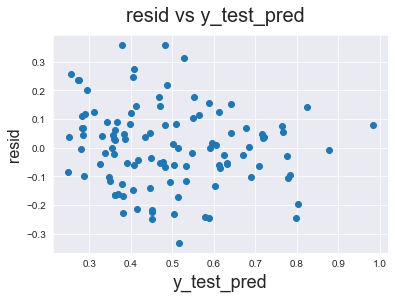

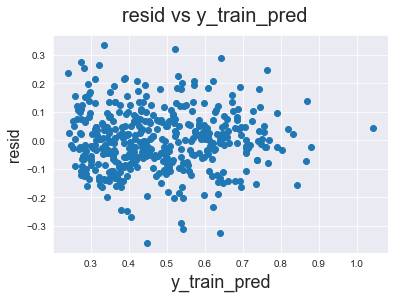

In [52]:
#Create the residual Plot
mEvalTest.plotResid("y_test_pred", "resid")
mEvalTrain.plotResid("y_train_pred", "resid")

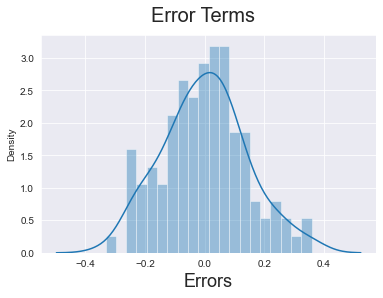

In [53]:
#Check normality of residuals
mEvalTest.plotResidDistribution()

In [54]:
residuals = y_train - y_train_pred
mean_residuals = np.mean(residuals)
print("Mean of Residuals {}".format(mean_residuals))

Mean of Residuals -5.652970446485888e-17


Text(0, 0.5, 'residuals')

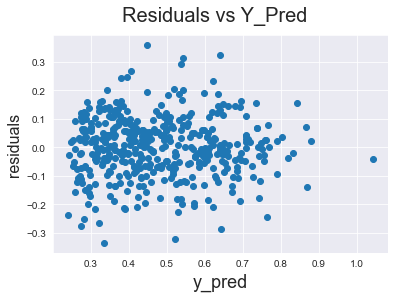

In [55]:
fig = plt.figure()
plt.scatter(y_train_pred, residuals)
fig.suptitle('{} vs {}'.format("Residuals", "Y_Pred"), fontsize = 20)              # Plot heading 
plt.xlabel("y_pred", fontsize = 18)                          # X-label
plt.ylabel("residuals", fontsize = 16)

In [56]:
#Test set metrics
mEvalTest.printMetrics()

Here are the evaluation results: 
----
MAE is 0.11070586371275018
MSE is 0.01948826207396358
RMSE is 0.1396003655939467
R-Squared is 0.6178254655303448


In [57]:
#Train set metrics
mEvalTrain.printMetrics()

Here are the evaluation results: 
----
MAE is 0.08074874839272538
MSE is 0.01091384883567074
RMSE is 0.10446936792989005
R-Squared is 0.6677139678755191


## 6. K-Fold Cross Validation

In [58]:
pipe

Pipeline(steps=[('selection',
                 RFE(estimator=LinearRegression(), n_features_to_select=8)),
                ('model', LinearRegression())])

In [59]:
scores = model_selection.cross_val_score(pipe, X_train, y_train,
                         scoring="r2",
                         cv=10, n_jobs=1)
# rmse = np.sqrt(-scores)
print("R2 scores: ", scores)
print("R2 values: ", np.round(scores, 2))
print("R2 average: ", np.mean(scores))


R2 scores:  [0.60079172 0.73345851 0.62478095 0.62144161 0.54377728 0.64154186
 0.68759618 0.56802118 0.64486205 0.51646261]
R2 values:  [0.6  0.73 0.62 0.62 0.54 0.64 0.69 0.57 0.64 0.52]
R2 average:  0.6182733941482466


## 7. Regularized Linear Models

In [60]:
def rmse_cv(alpha):
    rfe = RFE(estimator=lr, n_features_to_select=8)
    model = Ridge(alpha = alpha)
    pipe = Pipeline(steps=[('s',rfe), ('model', model)])
    
    rmse= model_selection.cross_val_score(pipe, X_train, y_train, scoring="r2", cv = 5)
    return(rmse)

In [61]:
alphas = [0.05, 0.1, 0.3, 1, 3]
cv_ridge = [rmse_cv(alpha).mean() 
            for alpha in alphas]

Text(0, 0.5, 'rmse')

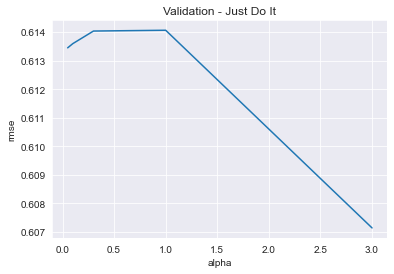

In [62]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")

In [63]:
numCols = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']

In [64]:
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[numCols].columns
vif['VIF'] = [variance_inflation_factor(X_train[numCols].values, i) for i in range(X_train[numCols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,bedrooms,4.53
0,area,3.50
3,stories,2.27
4,parking,1.90
2,bathrooms,1.58


# Pipeline of Linear Models

LR: 0.644561 (0.047705)
RD: 0.644681 (0.047588)
LSCV: 0.644570 (0.047743)
LLS: 0.644561 (0.047705)
BRD: 0.644745 (0.047377)
PR: 0.644561 (0.047705)
KR: 0.311399 (0.159498)
SVR: 0.622977 (0.027497)
LSVR: 0.645068 (0.047809)
KNN: 0.450234 (0.048809)


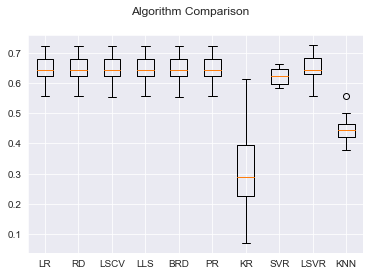

In [68]:
pipelines = []
pipelines.append(('LR', Pipeline([('LR', LinearRegression())])))
pipelines.append(('RD', Pipeline([('RD', RidgeCV())])))
pipelines.append(('LSCV', Pipeline([('LSCV', LassoCV())])))
pipelines.append(('LLS', Pipeline([('LLS', LassoLarsCV())])))
# pipelines.append(('MLS', Pipeline([('MLS', MultiTaskLasso())])))
# pipelines.append(('EN', Pipeline([('EN', ElasticNet())])))
# pipelines.append(('MTEN', Pipeline([('MTEN', MultiTaskElasticNet())])))
pipelines.append(('BRD', Pipeline([('BRD', BayesianRidge())])))
pipelines.append(('PR', Pipeline([('PR', PolynomialFeatures(degree=1)),('linear', LinearRegression(fit_intercept=False))])))
pipelines.append(('KR', Pipeline([('KR', KernelRidge(alpha=1))])))
pipelines.append(('SVR', Pipeline([('SVR', svm.SVR())])))
pipelines.append(('LSVR', Pipeline([('LSVR', svm.LinearSVR(random_state=0, tol=1e-05))])))
pipelines.append(('KNN', Pipeline([('KNN', KNeighborsRegressor(n_neighbors=50))])))


results = []
names=[]
for name, model in pipelines:
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    cv_results = cross_val_score(model, X_train_rfe, y_train, cv=kfold, scoring='r2')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()